In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel

In [2]:
# Load dataset
data=pd.read_csv("C:\\Users\\mo69fon\\Small_Molecules_SP\\SM+PD2.csv")
data

,Name,Solubility parameter,number of repeating units,Molecular weight,Connectivity index 0X,Connectivity index 1X,Connectivity index 0Xv,Connectivity index 1Xv,Quadrupole moment,Atomization energy (kJ/mol),...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,"2,2,3,3-tetramethylbutane",14.58,1,114.000,6.414214,3.457107,6.414214,3.457107,-41.98,10230.26,...,4.390033,14.062500,1.757812,0.000000,0.000000,0.0,58,9,4.844,38
1,"2,2,3-trimethylbutane",14.07,1,100.000,5.491564,3.127827,5.491564,3.127827,-36.86,9031.25,...,4.353270,12.293055,1.756151,0.000000,0.000000,0.0,42,6,4.238,30
2,"2,2-dimethyl-3-hexanol",19.31,1,130.000,6.905777,4.127827,6.352991,3.808676,-45.38,10653.67,...,4.819843,16.266070,1.807341,2.430904,2.430904,0.0,92,9,2.361,38
3,"2,2-dimethyl-3-pentanol",19.57,1,116.000,6.198671,3.627827,5.645884,3.308676,-40.05,9437.67,...,4.838338,14.275065,1.784383,2.396386,2.396386,0.0,63,8,1.792,34
4,"2,2-dimethylbutane",13.75,1,86.000,4.621320,2.707107,4.621320,2.707107,-31.76,7826.93,...,4.305478,10.465990,1.744332,0.000000,0.000000,0.0,28,3,3.730,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2-methyl-3-pentanol,20.70,1,102.170,5.276021,3.304530,4.723234,2.985379,-35.58,8227.16,...,4.862117,12.505243,1.786463,2.394392,2.394392,0.0,46,6,1.397,26
311,3-methyl-2-pentanol,21.11,1,102.170,5.276021,3.304530,4.723234,2.985379,-34.75,8224.03,...,4.862117,12.505243,1.786463,2.348368,2.348368,0.0,46,6,1.608,26
312,4-methyl-2-pentanol,21.37,1,102.170,5.276021,3.287694,4.723234,2.968542,-36.18,8228.90,...,4.862117,12.509162,1.787023,2.353722,2.353722,0.0,48,4,1.819,26
313,"3,3-dimethyl-2-butanol",20.21,1,102.170,5.491564,3.127827,4.938777,2.808676,-34.78,8224.63,...,4.862117,12.293055,1.756151,2.327350,2.327350,0.0,42,6,1.434,30


In [3]:
# Remove descriptors with all 0 columns
newdata=data.loc[:, (data != 0).any(axis=0)]
print('----- after removing rows with only 0 -----')
print('new data shape', newdata.shape)

----- after removing rows with only 0 -----
new data shape (315, 1083)


In [4]:
# Define target values and variables
cols = list(newdata.columns)
X = newdata.iloc[:,2:]
y = newdata.iloc[:,1] 
paras = cols[2:]

In [5]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Fill NaN values with column means (using the mean of the training set)
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)  # Use mean of training set to fill NaNs in test set

In [7]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Convert back to DataFrame for easier manipulation
X_train = pd.DataFrame(X_train, columns=cols[2:])
X_test = pd.DataFrame(X_test, columns=cols[2:])

In [9]:
# Calculate Pearson correlation coefficient (PCC) on training data
pearsonr_dict = {'Descriptor': [], 'Pearson correlation coefficient': []}

for i in range(X_train.shape[1]):
    x = X_train.iloc[:, i].tolist()
    result = pearsonr(x, y_train.tolist())
    pearsonr_dict['Descriptor'].append(cols[i + 2])
    pearsonr_dict['Pearson correlation coefficient'].append(result[0])

pearsonr_df = pd.DataFrame(pearsonr_dict)

# Select features with absolute PCC >= 0.5
pearson_select_df = pearsonr_df[abs(pearsonr_df['Pearson correlation coefficient']) >= 0.5]
selected_features = pearson_select_df['Descriptor'].tolist()

In [10]:
descriptor_list = pearson_select_df["Descriptor"].tolist()
print(descriptor_list)

['AATS0e', 'AATS1e', 'AATS1i', 'AATS0s', 'AATS1s', 'AATS2s', 'ATSC1e', 'AATSC0c', 'AATSC1c', 'AATSC1m', 'AATSC0e', 'AATSC1e', 'AATSC1s', 'MATS1c', 'BCUTw-1l', 'SpMin1_Bhm', 'SpMin1_Bhs', 'AVP-0', 'Mse', 'Mpe', 'Mare', 'SHBd', 'SHsOH', 'minHBd', 'maxHBd', 'meanI', 'hmax', 'hmin', 'ETA_AlphaP', 'ETA_dAlpha_B', 'ETA_Epsilon_1', 'ETA_Epsilon_2', 'ETA_dEpsilon_A', 'ETA_dEpsilon_D', 'ETA_Psi_1', 'ETA_dPsi_A', 'ETA_EtaP_L', 'nHBDon_Lipinski', 'SIC0', 'SIC1', 'CIC1', 'BIC0', 'BIC1']


In [11]:
len(pearson_select_df)

43

In [12]:
# Select features with absolute PCC >= 0.5
pearson_select_df_best = pearsonr_df[abs(pearsonr_df['Pearson correlation coefficient']) >= 0.59]
selected_features_best = pearson_select_df['Descriptor'].tolist()

In [13]:
pearson_select_df_best

,Descriptor,Pearson correlation coefficient
97,AATS1e,0.670883
124,AATS1s,0.611893
195,AATSC0c,0.746443
196,AATSC1c,-0.763231
223,AATSC1e,-0.719921
643,Mare,0.595566
838,hmax,0.650389
840,hmin,0.632308
852,ETA_dAlpha_B,0.674588
861,ETA_dEpsilon_D,0.749599


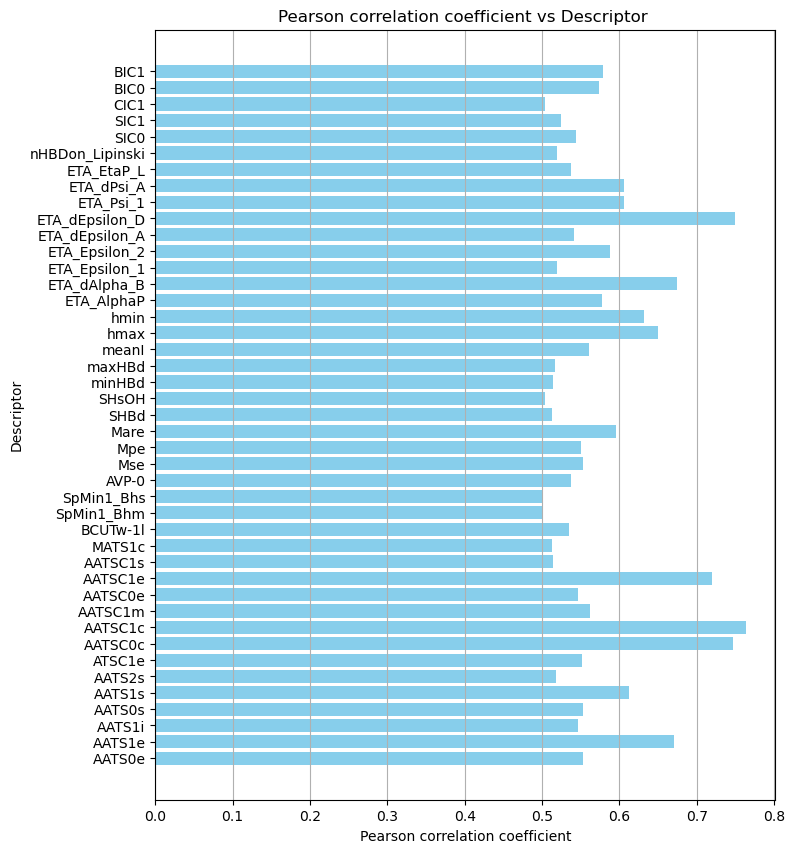

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

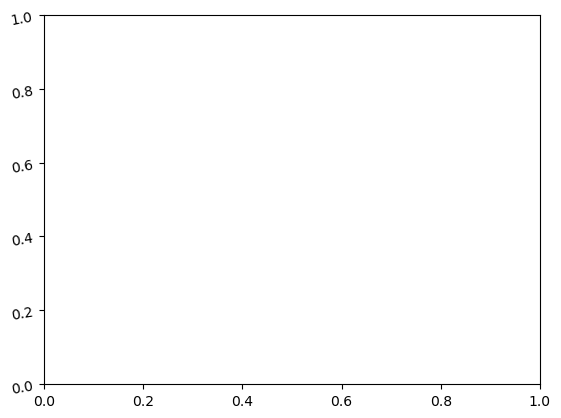

In [14]:
# Extracting data
descriptors = pearson_select_df['Descriptor']
correlation_coefficients = pearson_select_df['Pearson correlation coefficient'].abs()

# Plotting
plt.figure(figsize=(8,10))  # Adjust figure size as needed
plt.barh(descriptors, correlation_coefficients, color='skyblue')
plt.xlabel('Pearson correlation coefficient')
plt.ylabel('Descriptor')
plt.title('Pearson correlation coefficient vs Descriptor ')
plt.grid(axis='x')  # Add gridlines for better readability
plt.show()
# Adjust font size of y-axis labels for better visibility
plt.yticks(rotation=10)  # Adjust font size as needed
#plt.show()
# Save the plot
#plt.savefig('pearson_correlation_plot.png', bbox_inches='tight')  # Adjust file name and DPI as needed

In [15]:
# Extract selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [16]:
# Define GPR kernel
kernel_matern = Matern(length_scale=1.0, nu=1.5) + WhiteKernel(noise_level=1.0)

In [17]:
from sklearn.model_selection import KFold
gpr_model = GaussianProcessRegressor(kernel=kernel_matern, alpha=1e-2, normalize_y=True, random_state=42)

In [20]:
# Fit the model
gpr_model.fit(X_train_selected, y_train)

,kernel,Matern(length...noise_level=1)
,alpha,0.01
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,"Matern(length_scale=1, nu=1.5)"
,kernel__k2,WhiteKernel(noise_level=1)
,kernel__k1__length_scale,1.0


In [21]:
print("Optimized kernel:", gpr_model.kernel_)

Optimized kernel: Matern(length_scale=6.21, nu=1.5) + WhiteKernel(noise_level=0.0322)


In [22]:
num_runs=5
run_times_seconds=[]
for run in range(num_runs):
    start_time = time.time()
    gpr_model.fit(X_train_selected, y_train)
    end_time = time.time()
    elapsed_time_sec = end_time - start_time
    run_times_seconds.append(elapsed_time_sec)
    elapsed_time_min = elapsed_time_sec / 60
    print(f"Run {run + 1}: {elapsed_time_sec:.2f} seconds ({elapsed_time_min:.2f} minutes)")
    
# Compute average and std dev
avg_sec = np.mean(run_times_seconds)
std_sec = np.std(run_times_seconds)
avg_min = avg_sec / 60
std_min = std_sec / 60

# Final output
print(f"\nAverage training time: {avg_sec:.2f} seconds ({avg_min:.2f} minutes)")
print(f"Standard deviation: {std_sec:.2f} seconds ({std_min:.2f} minutes)")

Run 1: 0.07 seconds (0.00 minutes)
Run 2: 0.10 seconds (0.00 minutes)
Run 3: 0.09 seconds (0.00 minutes)
Run 4: 0.09 seconds (0.00 minutes)
Run 5: 0.08 seconds (0.00 minutes)

Average training time: 0.09 seconds (0.00 minutes)
Standard deviation: 0.01 seconds (0.00 minutes)


In [23]:
# Make predictions
y_train_pred = gpr_model.predict(X_train_selected)
y_test_pred = gpr_model.predict(X_test_selected)

In [24]:
# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [25]:
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [26]:
train_r2

0.9733257672484482

In [27]:
test_r2

0.9156431375686096

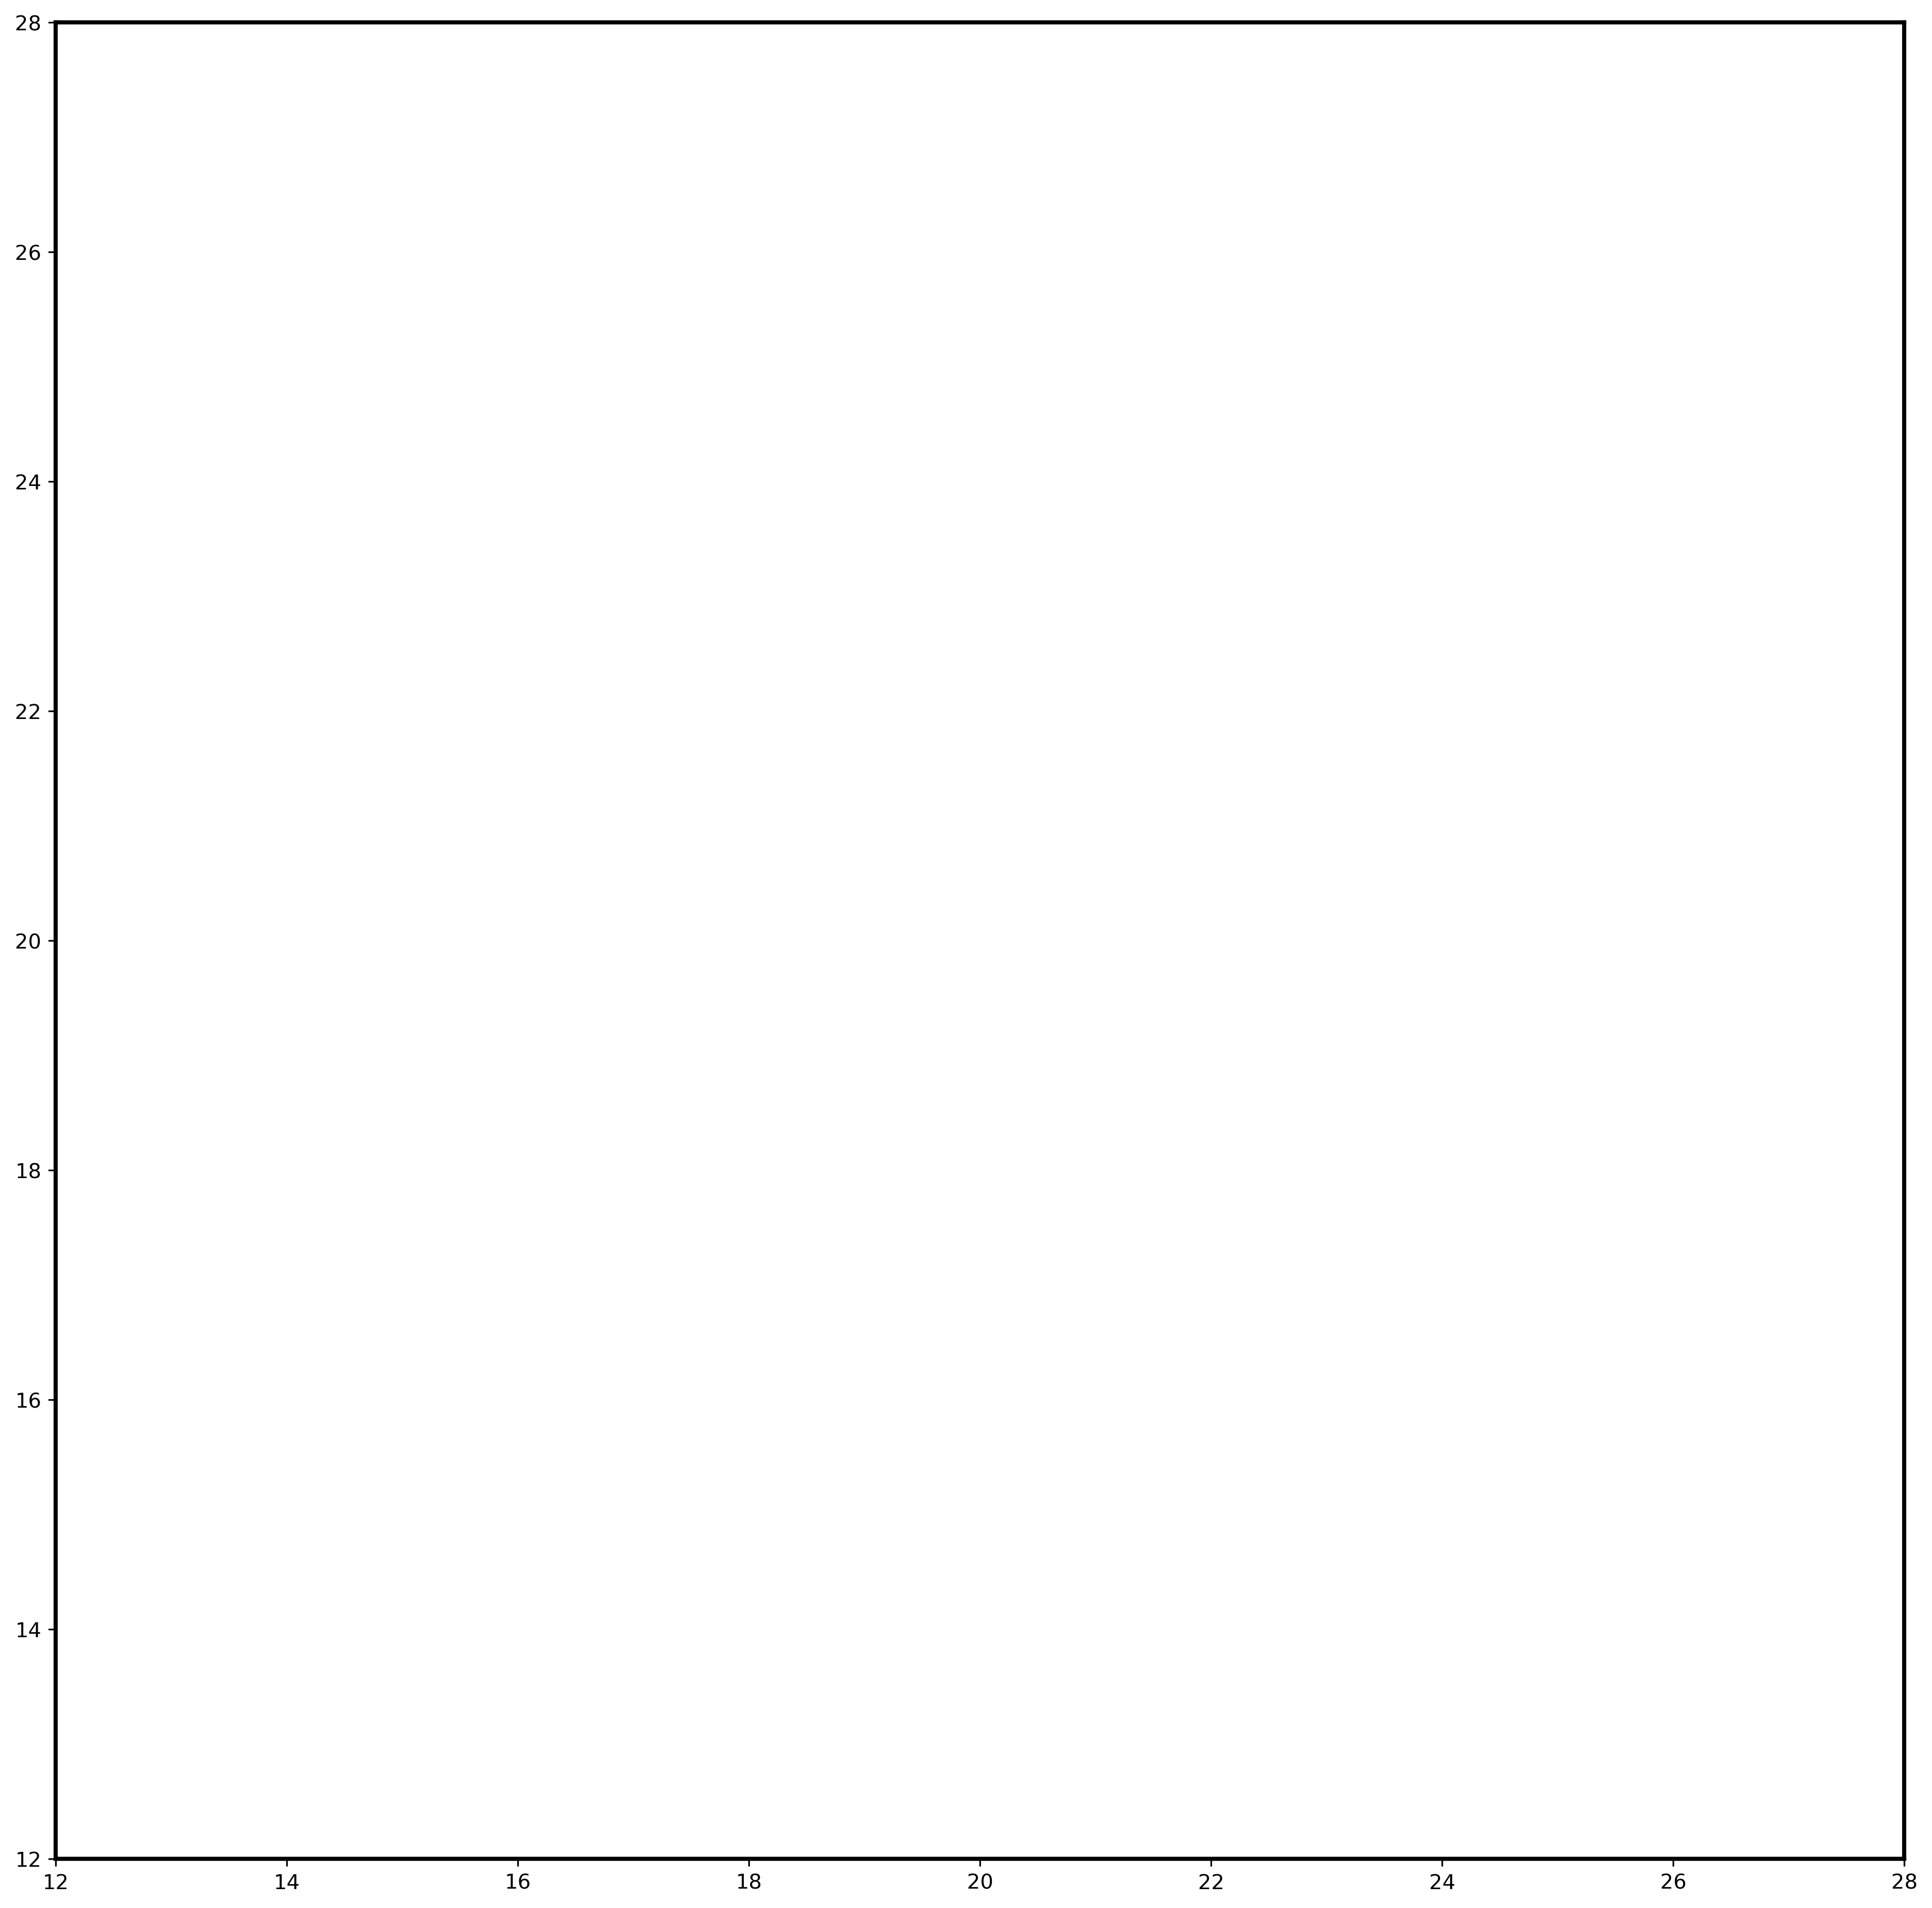

In [28]:
# Plot the predicted values versus the true values for the training and test sets
f, ax = plt.subplots(figsize=(16, 16),dpi=300)
plt.xlim((12, 28))
plt.ylim((12, 28))
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)

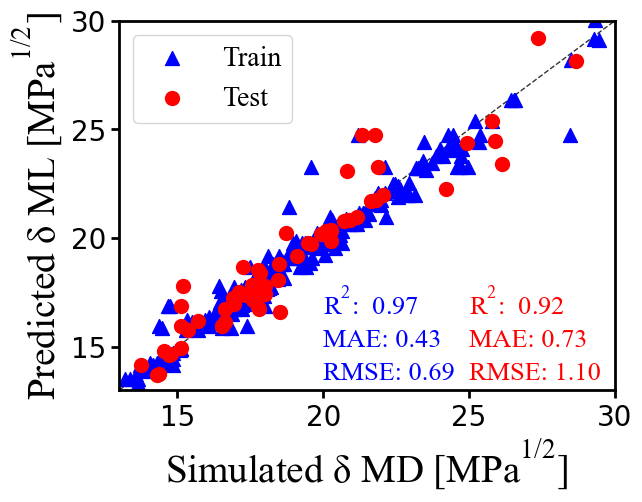

In [35]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FixedLocator
orange_accent2 = (255/255, 192/255, 0/255)
plt.plot([12, 30], [12, 30], ls="--", c=".2", linewidth=1, zorder=1)
plt.scatter(y_train, y_train_pred, c='blue', marker='^', s=100, label='Train', zorder=2)
plt.scatter(y_test, y_test_pred, c='red', marker='o', s=100, label='Test', zorder=2)
plt.xlim(13, 30)
plt.xticks([])
plt.ylim(13, 30)

# Set fixed ticks at 15, 20, 25, 30 only
ax = plt.gca()
ax.xaxis.set_major_locator(FixedLocator([15, 20, 25, 30]))
ax.yaxis.set_major_locator(FixedLocator([15, 20, 25, 30]))
# Set font properties
font_properties = {'family': 'Times New Roman', 'size': 28}

# Apply black border and customize ticks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(2)

# Increase tick size and label size
plt.tick_params(axis='both', which='major', labelsize=20, width=2, length=6)


plt.xlabel('Simulated δ MD [$\mathregular {MPa^{1/2}}$]',fontsize=28,family= 'Times New Roman')
plt.ylabel('Predicted δ ML [$\mathregular {MPa^{1/2}}$]',fontsize=28,family= 'Times New Roman')

# Legend
plt.legend(loc='upper left', prop={'size': 20, 'family': 'Times New Roman'})

plt.annotate("$\mathregular {{R^{{2}}}}$: {:5.2f}".format(test_r2),
        (22, 14), xytext=(25, 16.5),
        fontsize=19,family= 'Times New Roman',c='red')
plt.annotate("MAE:{:5.2f}".format(test_mae),
        (22, 14), xytext=(25, 15),
        fontsize=19,family= 'Times New Roman',c='red')
plt.annotate("RMSE:{:5.2f}".format(test_rmse),
        (22, 14), xytext=(25, 13.5),
        fontsize=19,family= 'Times New Roman',c='red')
plt.annotate("$\mathregular {{R^{{2}}}}$: {:5.2f}".format(train_r2),
        (22, 14), xytext=(20, 16.5),
        fontsize=19,family= 'Times New Roman',c='blue')
plt.annotate("MAE:{:5.2f}".format(train_mae),
        (22, 14), xytext=(20, 15),
        fontsize=19,family= 'Times New Roman',c='blue')
plt.annotate("RMSE:{:5.2f}".format(train_rmse),
        (22, 14), xytext=(20, 13.5),
        fontsize=19,family= 'Times New Roman',c='blue')

#plt.savefig('PCC_GPR_kernel2_final3.png', bbox_inches='tight', dpi=800)
plt.show()